In [2]:
# Some standard import statements that are nice for Jupyter

import sys
import os
import logging

import numpy as np

from scipy.optimize import curve_fit

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.dpi'] = 200

import time

import json

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

# importing my model functions for analysis
from psi_transmission.model import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Method 3 - Fitting to the Normalization Storage Measurements

Each time the normalization configuration was set up, a single direct shot measurement was followed by a series of storage measurements. To use them in the analysis, we can perform independent fits of the 5 second, 20 second, and 100 second runs, spanning the entirety of the experiment, but restricted to this one configuration. 

### The List of Relevant Runs

Run #'s                      | Day |  Storage Time (s)   | Configuration          |
---                          | --- |      ---            | ---                    |
 22 - 24                     | 8   |       20            | normalization          |
 25 - 31                     | 8   |      100            | normalization          |
 32 - 35                     | 8   |        5            | normalization          |
 77 - 79                     | 8   |        5            | normalization          |
 80 - 82                     | 8   |       20            | normalization          |
 83 - 88                     | 8   |      100            | normalization          |
121 - 123                    | 9   |        5            | normalization          |
124 - 125                    | 9   |       20            | normalization          |
      127                    | 9   |       20            | normalization          |
128 - 135                    | 9   |      100            | normalization          |
176 - 183                    | 9   |      100            | normalization          |
184 - 186                    | 9   |       20            | normalization          |
187 - 189                    | 9   |        5            | normalization          |
123 - 130                    | 10  |      100            | normalization          |
131 - 133                    | 10  |       20            | normalization          |
134 - 136                    | 10  |        5            | normalization          |
171 - 179                    | 10  |      100            | normalization          |
180 - 182                    | 10  |       20            | normalization          |
183 - 185                    | 10  |        5            | normalization          |
250 - 252                    | 10  |        5            | normalization          |
253 - 255                    | 10  |       20            | normalization          |
256 - 265                    | 10  |      100            | normalization          |

The direct shot measurements that precede all these are:

Run #'s                      | Day |  Storage Time (s)   | Configuration          |
---                          | --- |      ---            | ---                    |
      76                     | 8   |   direct            | normalization          |
      120                    | 9   |   direct            | normalization          |
      175                    | 9   |   direct            | normalization          |
      122                    | 10  |   direct            | normalization          |
      170                    | 10  |   direct            | normalization          |
      249                    | 10  |   direct            | normalization          |

We'll put together a plot of all the relevant measurements, so we can investigate the source performance over time.

Fit parameters will be printed in 5, 20, 100, shot order

Fit parameters:
 N_0 = 133207.5917926881 +/- 205.94389839717735,
 A: -0.2409296662955255 +/- 0.0009011676449929654
Fit parameters:
 N_0 = 69776.49496952021 +/- 159.37541128580816,
 A: -0.12111801797553855 +/- 0.0006893228360485554
Fit parameters:
 N_0 = 5466.394384902607 +/- 29.78056981356517,
 A: -0.00894578488227862 +/- 0.0001251561867271066
Fit parameters:
 N_0 = 4195634.705589446 +/- 2678.769089619999,
 A: -8.590787357807985 +/- 0.011104404866708075


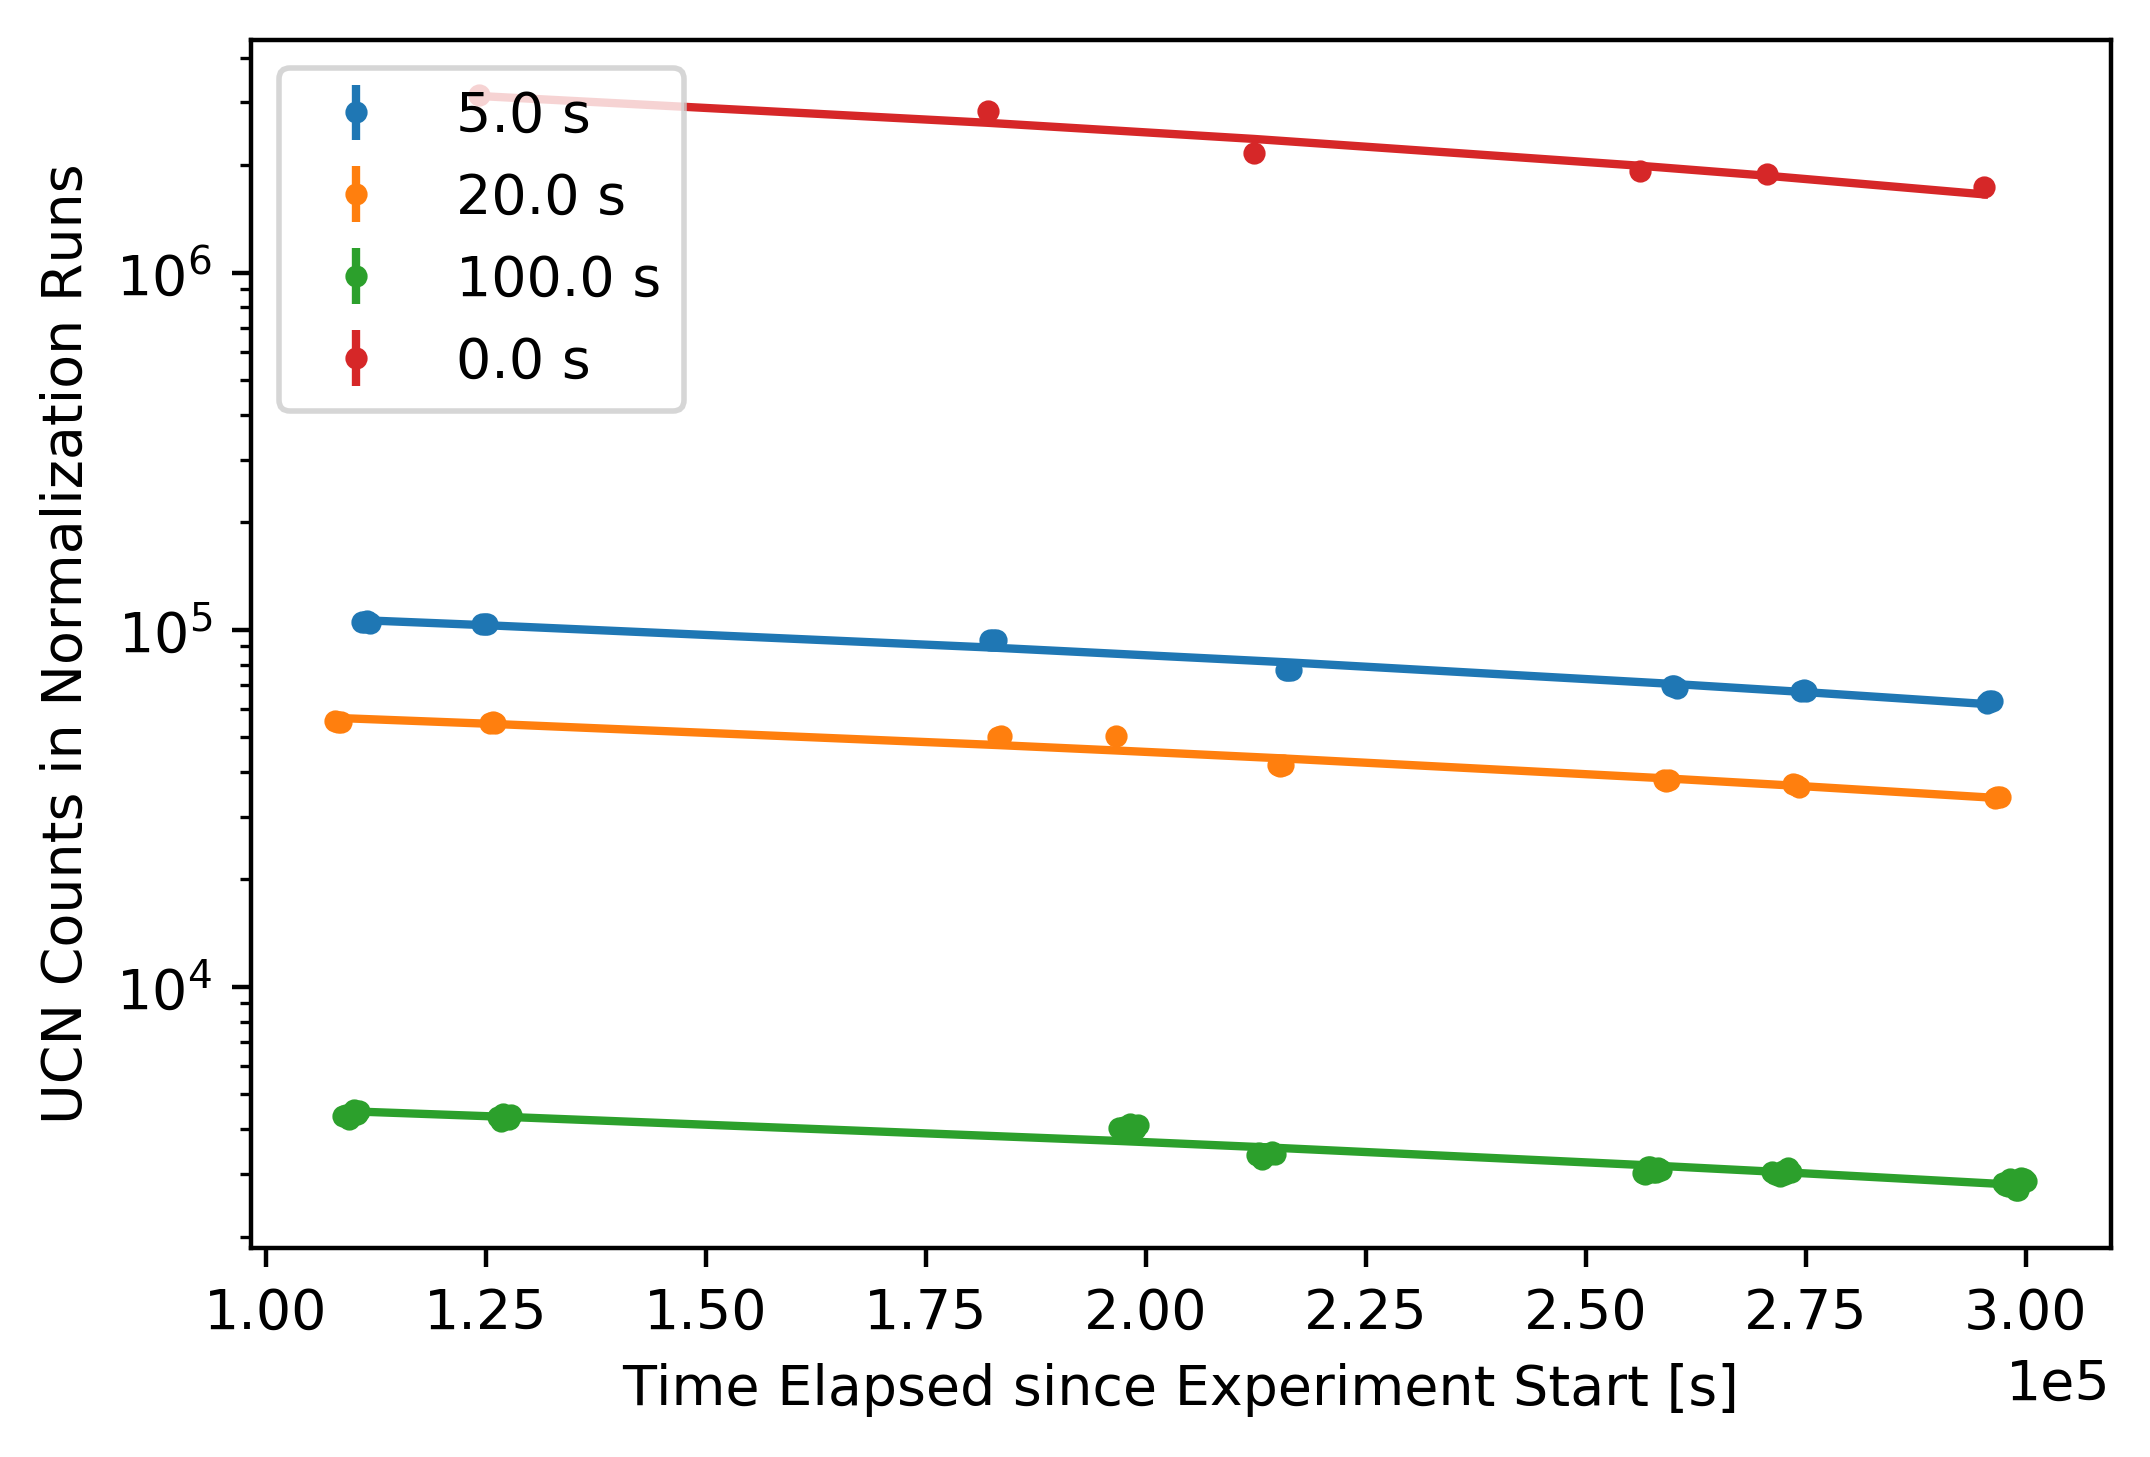

In [61]:
config = "NORM"

data_5    = load_data_2(config, 's005', normalize_flag = False)
data_20   = load_data_2(config, 's020', normalize_flag = False)
data_100  = load_data_2(config, 's100', normalize_flag = False)
data_shot = load_data_2(config, 'shot', normalize_flag = False)
data_list = [data_5, data_20, data_100, data_shot]

# converting to days
# for arr in data_list:
#     arr[:,0] = arr[:,0] / 60 / 60 / 24
#     xlabel = 'Time Elapsed since Experiment Start [day]'

# staying in seconds
xlabel = 'Time Elapsed since Experiment Start [s]'

print('Fit parameters will be printed in 5, 20, 100, shot order\n')
# fitting
ax = plt.gca()
for arr in data_list:
    color = next(ax._get_lines.prop_cycler)['color']
    plt.errorbar(arr[:,0], arr[:,2], yerr = arr[:,3], fmt = '.', label = '{} s'.format(arr[0,1]), color = color)
    popt, pcov = curve_fit(source_fit, arr[:,0], arr[:,2], p0=[77600, -9], sigma = arr[:,3], absolute_sigma = True)
    plt.plot(arr[:,0], source_fit(arr[:,0], *popt), color = color);

    # printing the fit parameters and their errors:
    fit_parameters = np.zeros(np.shape(pcov))
    for i in range(0, np.size(popt)):
        fit_parameters[i,0] = popt[i]
        fit_parameters[i,1] = np.sqrt(np.diag(pcov))[i]
    print("Fit parameters:\n N_0 = {} +/- {},\n A: {} +/- {}".format(
            fit_parameters[0,0],
            fit_parameters[0,1],
            fit_parameters[1,0],
            fit_parameters[1,1]))
    
plt.legend()
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xlabel(xlabel)
plt.ylabel('UCN Counts in Normalization Runs');
plt.yscale('log')

The 0 second data are that of the direct shot measurements. In order to properly compare the fits we would need to perform a normalization of all points. 

Here a very rudimentary normalization routine has been applied, where all data points are normalized to the ratio between the first point of each set. However these first few points themselves are happening at different times, and thus they are not directly comparable in this way. This isn't an ideal analysis. We see near agreement, however there is clearly a trend wherein the longer storage time measurements are less sensitive to the degradation of the UCN source performance. The mechanism for source degradation is believed to be crystal impurities, but more of the physics behind this mechanism would need to be understoos if the behaviour here is to be explained. The effect of long pre-storage times is to cut off the higher energy parts of the UCN spectrum. Is there an energy dependence to the degradation of UCN production over time within the source? This would certainly suggest as much.

> !!! This question is good for Bernhard

> !!! A good question for either Bernhard or Edgard might be to clarify the exact time sequence of the data, down to beam coming on and off, and valves being opened and closed. 

We can move forward with the implementation of a normalization that is specific to the type of measurement performed. Here we have four types, and every run's counts will be normalized in accordance with its specific type. I have added a "normalize_flag" to data_load_2() to perform this operation. It is demonstrated below.

Fit parameters will be printed in 5, 20, 100, shot order

Fit parameters:
 N_0 = 133207.5917926881 +/- 205.94389839717735,
 A: -0.2409296662955255 +/- 0.0009011676449929654
Fit parameters:
 N_0 = 131898.12125648904 +/- 301.26645780941453,
 A: -0.228948717488606 +/- 0.0013030231383329238
Fit parameters:
 N_0 = 132415.20247805282 +/- 721.389627759341,
 A: -0.21669821692684788 +/- 0.0030317208571560353
Fit parameters:
 N_0 = 140281.8017159543 +/- 89.56512556801201,
 A: -0.2872345215786589 +/- 0.00037127777423301596


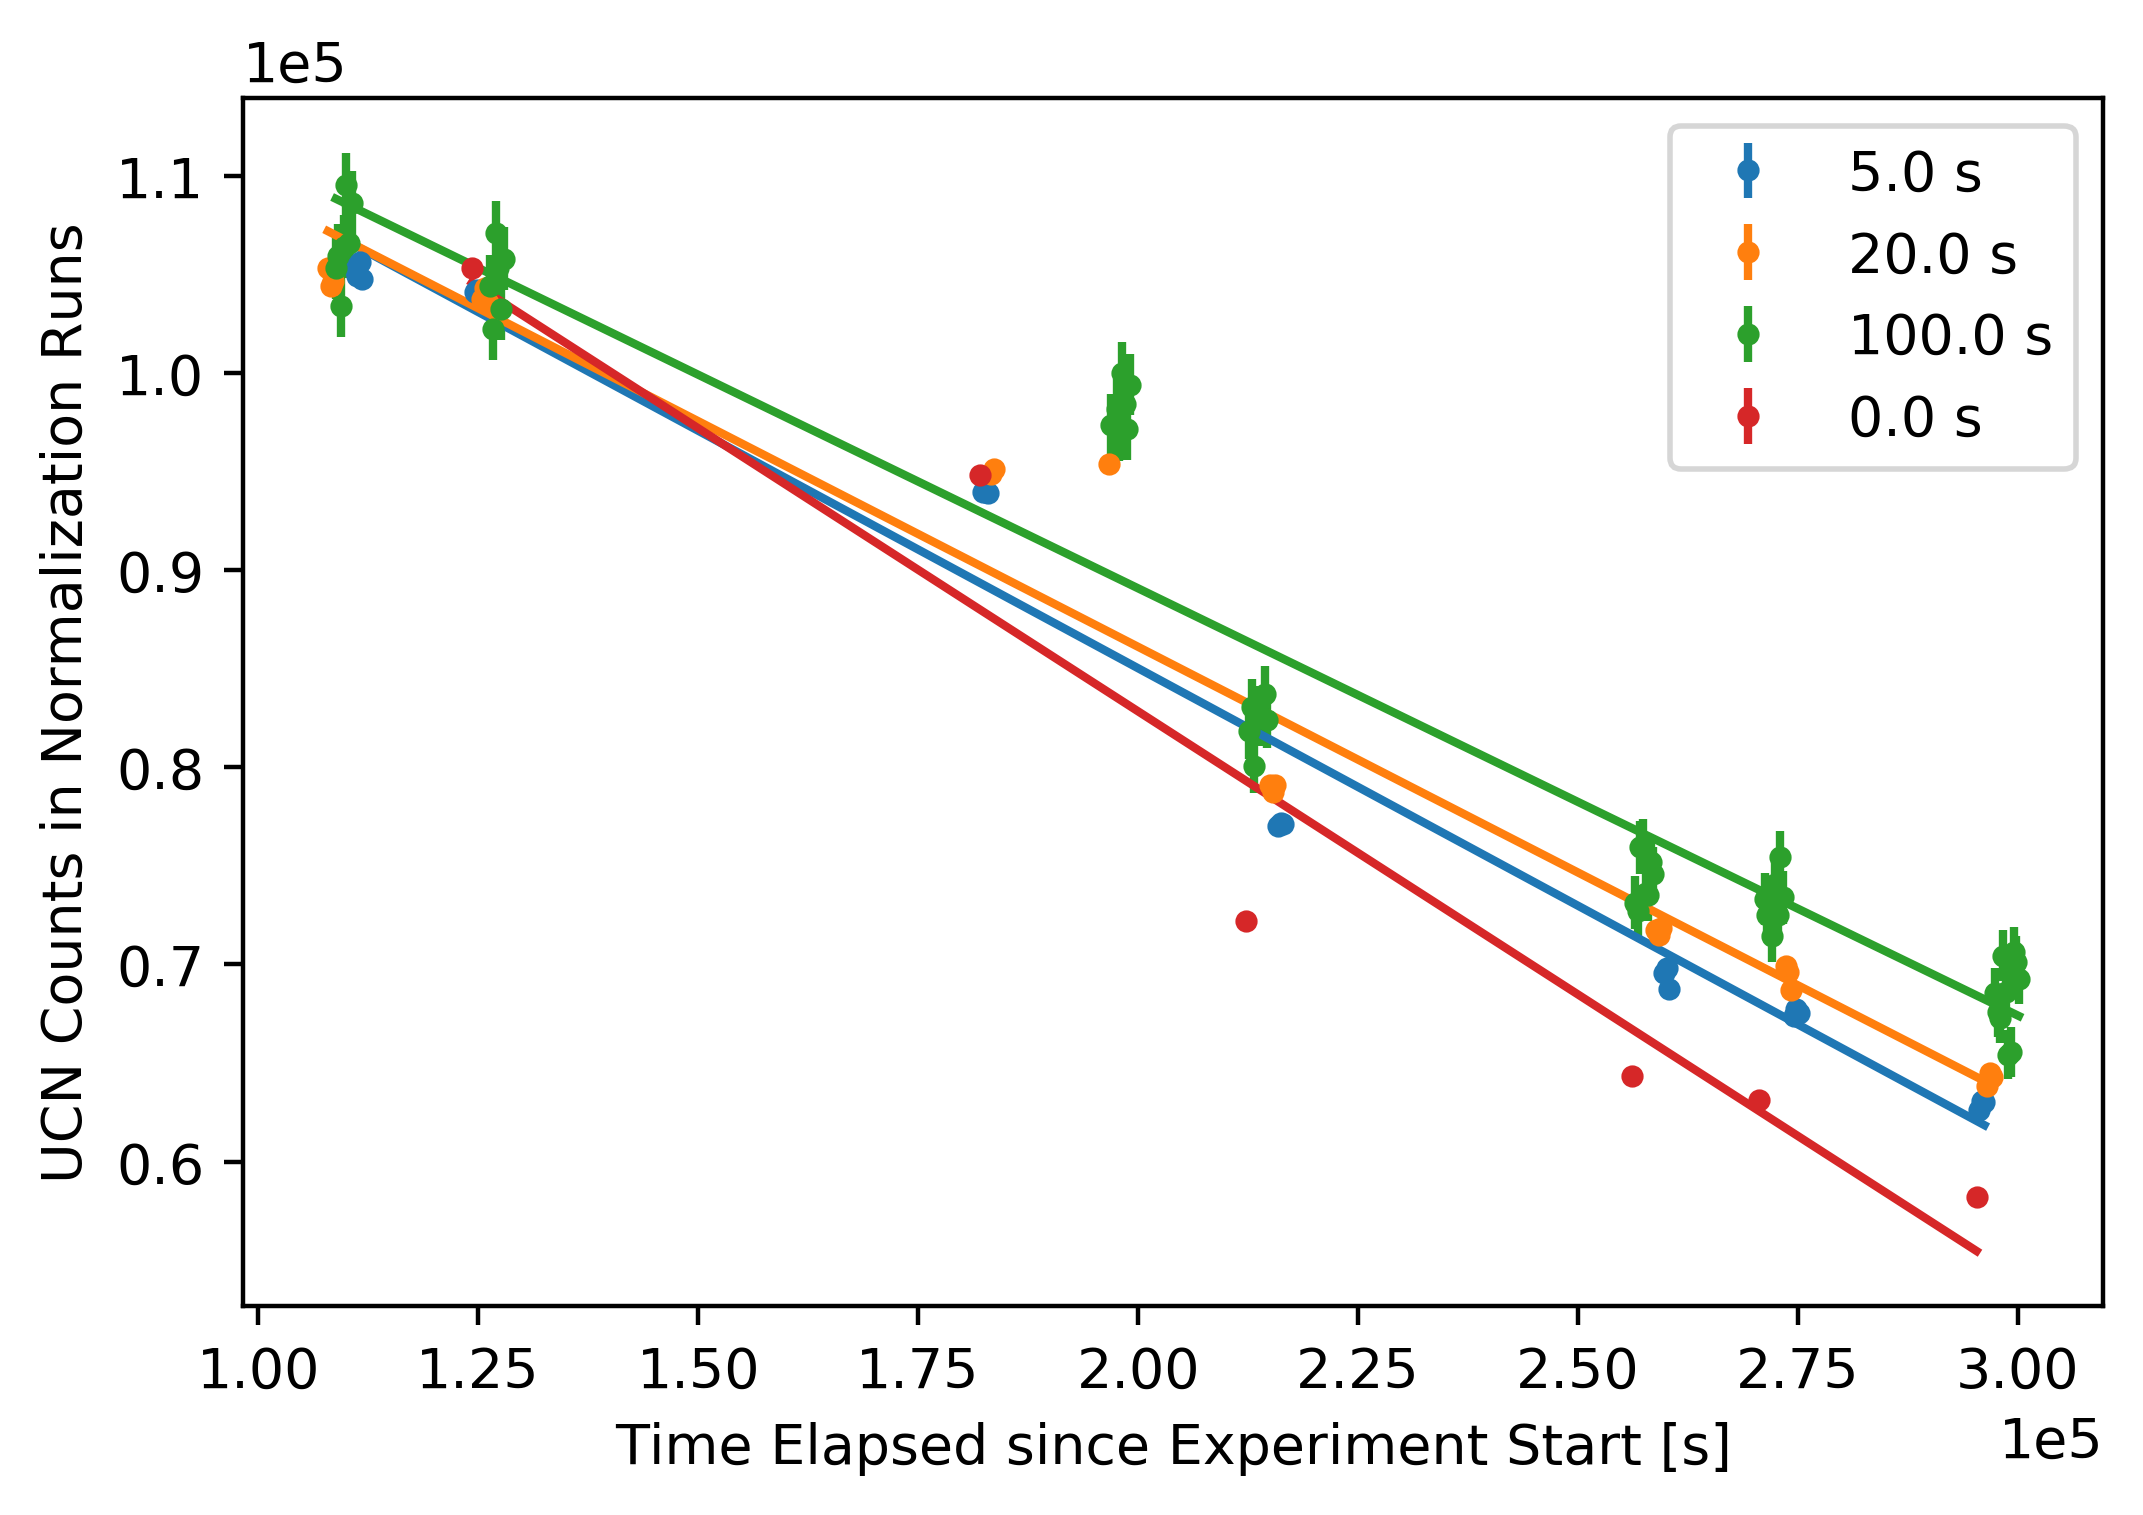

In [62]:
config = "NORM"

data_5    = load_data_2(config, 's005', normalize_flag = False)
data_20   = load_data_2(config, 's020', normalize_flag = False)
data_100  = load_data_2(config, 's100', normalize_flag = False)
data_shot = load_data_2(config, 'shot', normalize_flag = False)
data_list = [data_5, data_20, data_100, data_shot]

# A normalization for absolute counts
for arr in data_list:
    norm_factor = (data_list[0][0,2] / arr[0,2])
    arr[:,2] = arr[:,2] * norm_factor
    arr[:,3] = arr[:,3] * norm_factor

# converting to days
# for arr in data_list:
#     arr[:,0] = arr[:,0] / 60 / 60 / 24
#     xlabel = 'Time Elapsed since Experiment Start [day]'

# staying in seconds
xlabel = 'Time Elapsed since Experiment Start [s]'

print('Fit parameters will be printed in 5, 20, 100, shot order\n')
# fitting
ax = plt.gca()
for arr in data_list:
    color = next(ax._get_lines.prop_cycler)['color']
    plt.errorbar(arr[:,0], arr[:,2], yerr = arr[:,3], fmt = '.', label = '{} s'.format(arr[0,1]), color = color)
    popt, pcov = curve_fit(source_fit, arr[:,0], arr[:,2], p0=[77600, -9], sigma = arr[:,3], absolute_sigma = True)
    plt.plot(arr[:,0], source_fit(arr[:,0], *popt), color = color);

    # printing the fit parameters and their errors:
    fit_parameters = np.zeros(np.shape(pcov))
    for i in range(0, np.size(popt)):
        fit_parameters[i,0] = popt[i]
        fit_parameters[i,1] = np.sqrt(np.diag(pcov))[i]
    print("Fit parameters:\n N_0 = {} +/- {},\n A: {} +/- {}".format(
            fit_parameters[0,0],
            fit_parameters[0,1],
            fit_parameters[1,0],
            fit_parameters[1,1]))
    
plt.legend()
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xlabel(xlabel)
plt.ylabel('UCN Counts in Normalization Runs');
# plt.yscale('log')

Fit parameters:
 N_0 = 133207.5945824243 +/- 228.05867454065873,
 A: -2.231843332367589e-08 +/- 0.0009986688573663568
Fit parameters:
 N_0 = 69776.486943231 +/- 186.24178654083605,
 A: 5.3179459058583234e-08 +/- 0.0008405562805048948
Fit parameters:
 N_0 = 5466.390409581145 +/- 34.66447715298638,
 A: 1.8705815563180295e-08 +/- 0.00015150376070479938
Fit parameters:
 N_0 = 4195635.767372111 +/- 3635.5394922520704,
 A: -5.0490943195313776e-06 +/- 0.01544452169990635


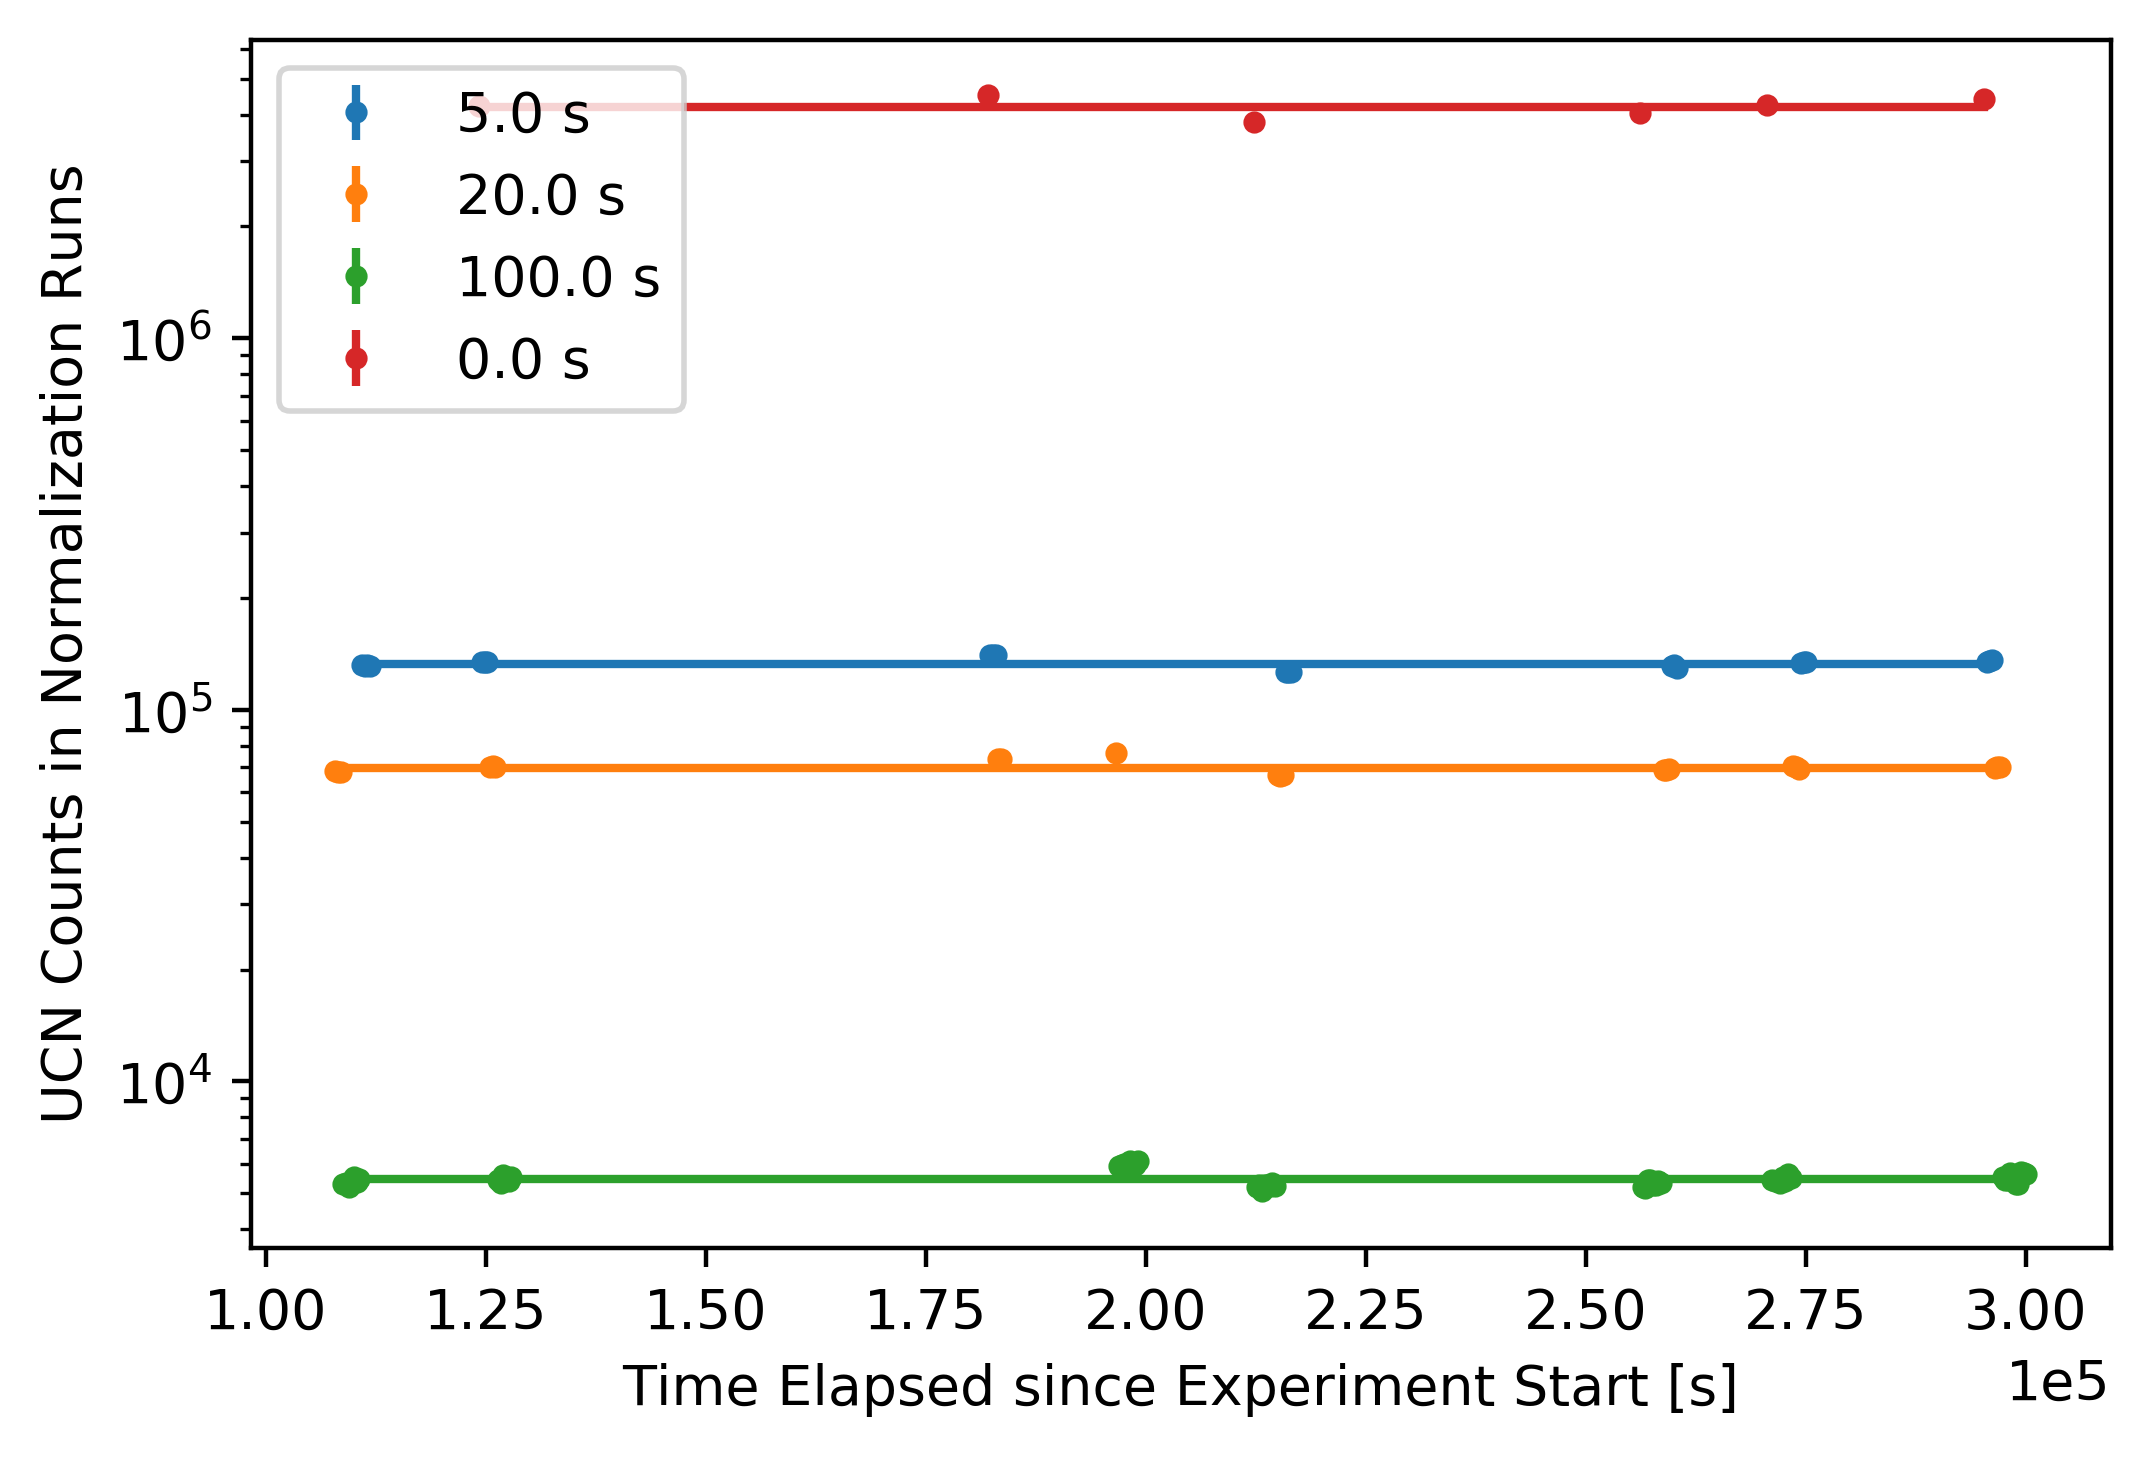

In [19]:
config = "NORM"

data_5    = load_data_2(config, 's005', normalize_flag = True)
data_20   = load_data_2(config, 's020', normalize_flag = True)
data_100  = load_data_2(config, 's100', normalize_flag = True)
data_shot = load_data_2(config, 'shot', normalize_flag = True)
data_list = [data_5, data_20, data_100, data_shot]

# converting to days
# for arr in data_list:
#     arr[:,0] = arr[:,0] / 60 / 60 / 24
#     xlabel = 'Time Elapsed since Experiment Start [day]'

# staying in seconds
xlabel = 'Time Elapsed since Experiment Start [s]'

# print('Fit parameters will be printed in 5, 20, 100, shot order\n')
# fitting
ax = plt.gca()
for arr in data_list:
    color = next(ax._get_lines.prop_cycler)['color']
    plt.errorbar(arr[:,0], arr[:,2], yerr = arr[:,3], fmt = '.', label = '{} s'.format(arr[0,1]), color = color)
    popt, pcov = curve_fit(source_fit, arr[:,0], arr[:,2], p0=[77600, -9], sigma = arr[:,3], absolute_sigma = True)
    plt.plot(arr[:,0], source_fit(arr[:,0], *popt), color = color);

    # printing the fit parameters and their errors:
    fit_parameters = np.zeros(np.shape(pcov))
    for i in range(0, np.size(popt)):
        fit_parameters[i,0] = popt[i]
        fit_parameters[i,1] = np.sqrt(np.diag(pcov))[i]
    print("Fit parameters:\n N_0 = {} +/- {},\n A: {} +/- {}".format(
            fit_parameters[0,0],
            fit_parameters[0,1],
            fit_parameters[1,0],
            fit_parameters[1,1]))
    
plt.legend()
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xlabel(xlabel)
plt.ylabel('UCN Counts in Normalization Runs');
plt.yscale('log')

For each run type, a fit is performed using the runs from the normalization configuration. Then to determine the factor by which to normalize, we compute the ratio:

$$\frac{\text{Extrapolated Counts at }t=0}{\text{Interpolated Counts at }t=t_s}$$

where $t=0$ is defined by the time of the very first monitor count run on December 7th, and $t=t_s$ is the start time of the run in question.